# Quantum Computing -based Optimization for Sustainable Data Workflows in Cloud Infrastructures

by [Valter Uotila](https://researchportal.helsinki.fi/en/persons/valter-johan-edvard-uotila), PhD student, [Unified Database Management Systems](https://www2.helsinki.fi/en/researchgroups/unified-database-management-systems-udbms/news), University of Helsinki

This is just a specified shortest path finding application applied to the problem presented in the [document](https://github.com/valterUo/Quantum-Computing-based-Optimization-for-Sustainable-Data-Workflows-in-Cloud/blob/main/Quantum_Computing__based_Optimization_for_Sustainable_Data_Workflows_in_Cloud.pdf) that comes along with this implementation.

Possible quantum software-harware combinations to solve the problem:

1. Amazon Braket's D-Wave — Advantage and D-Wave — 2000Q
    1. Ocean implementation of this code
2. Amazon Braket's IonQ and Rigetti machines
    1. Qiskit implementation of this code
3. Amazon Braket's simulators
    1. Qiskit implementation of this code
4. D-wave's Leap Advantage
    1. Ocean implementation of this code
5. IBM Quantum systems
    1. Qiskit implementation of this code
6. Local machine
    1. Both Ocean and Qiskit versions and also the non-quantum version of the algorithm

Because I am familiar with the Ocean framework and it is specially designed for formulating QUBOs, I initially formulated the problem using it.

## Chapter 1: Implementation using Ocean connecting to Amazon Braket quantum annealers or D-wave Leap quantum annealers

In [1]:
import dimod
from dimod.generators.constraints import combinations
from dwave.system import LeapHybridSampler
from hybrid.reference import KerberosSampler
from dwave.system.composites import EmbeddingComposite

from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler

import numpy as np
import json
import itertools
import os
import math
import networkx as nx
import matplotlib.pyplot as plt

from ipynb.fs.defs.emission_simulator import emission_simulator

notebook_path = os.path.abspath("main.ipynb")

In [2]:
def append_linear_safe(variable, value, linear_dict):
    if variable in linear_dict.keys():
        linear_dict[variable] = linear_dict[variable] + value
    else:
        linear_dict[variable] = value

def append_quadratic_safe(variable, value, quadratic_dict):
    if variable in quadratic_dict.keys():
        quadratic_dict[variable] = quadratic_dict[variable] + value
    else:
        quadratic_dict[variable] = value

## Importing data

In [3]:
cloud_partners_file_path = os.path.join(os.path.dirname(notebook_path), "data/cloud_partners.json")
f = open(cloud_partners_file_path)
partners_root = json.load(f)
cloud_partners = partners_root["cloud_partners"]

workload_name = "workload1.json"
workload_file_path = os.path.join(os.path.dirname(notebook_path), "data/workloads/" + workload_name)
f = open(workload_file_path)
workload_root = json.load(f)
workload = workload_root["workload"]

#print(cloud_partners)
#print(workload)

## Creating variables for the binary quadratic model

We defined variables to be $ x_{i,j} = (w_i, d_j) $.

In [4]:
vartype = dimod.BINARY
bqm = dimod.BinaryQuadraticModel({}, {}, 0.0, vartype)
variables = dict()
workload_order = []

# We assume that any work can be executed on any data center
for work in workload:
    variables[str(work["work_id"])] = list()
    workload_order.append(str(work["work_id"]))
    for partner in cloud_partners:
        for center in partner["data_centers"]:
            # The each key in the variables dictionary corresponds to a level in a tree i.e. a time step in the workflow
            variables[str(work["work_id"])].append((str(work["work_id"]), center["center_id"]))
            
#print(json.dumps(variables, indent=1))

## Constructing constraints 

### Constraint 1

This constraint implements the requirement that for every work $ w_i $ we have exactly one variable $ x_{i,j} = (w_i, d_j) = 1$. In other words, this means that every work is executed on a single data center.

In [5]:
strength = 25.0
for work_id in variables:
    one_work_bqm = combinations(variables[work_id], 1, strength=strength)
    bqm.update(one_work_bqm)

### Constraint 2

This constraint implements the requirement that for every pair of variables $x_{i,j} = (w_i, d_j)$ and $x_{i+1,k} = (w_{i+1}, d_k)$ we associate the (estimated emission) coefficient $e(x_{i,j}, x_{i+1,k})$. This coefficient is calculated in emission_simulator function. Note that we need to calculate this only for those pairs, where the works $w_i$ and $w_{i+1}$ are consecutive works in the workload.

To evaluate the algorithm we store the tree in a networkx graph.

The problem is to find the minimum path from some of the nodes ('0', x) to some of the nodes ('5', y). The weight of the edges are defined by carbon footprint associated to the computation.


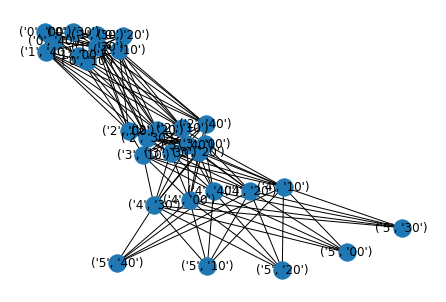

In [6]:
A = 1
linear = dict()
quadratic = dict()
offset = 0.0
tree = nx.Graph()

for work_id_current in range(len(workload_order) - 1):
    work_id_next = work_id_current + 1
    key_current = workload_order[work_id_current]
    key_next = workload_order[work_id_next]
    
    for work1 in variables[key_current]:
        for work2 in variables[key_next]:
            coeff = emission_simulator(work1, work2, cloud_partners, workload)
            append_quadratic_safe((work1, work2), coeff, quadratic)
            tree.add_edge(work1, work2, weight=coeff)
            
            #print("Works", work1, work2)
            #print("Coefficient", coeff)
    
bqm_c2 = dimod.BinaryQuadraticModel(linear, quadratic, offset, vartype)
bqm_c2.scale(A)
bqm.update(bqm_c2)

print("The problem is to find the minimum path from some of the nodes ('0', x) to some of the nodes ('5', y). The weight of the edges are defined by carbon footprint associated to the computation.")
nx.draw(tree, with_labels = True)

#print(bqm)
#print(bqm.to_numpy_vectors())


## Updating BQM while workflow proceeds

To make the problem and solution less non-trivial, we include the time component in the algorithm. One time step means that we have executed a single work on some of the data centers. At each time step, we check the current situation how sustainable way the data centers are running. For example, weather conditions (wind and amount of water in rivers, etc.) affect the production of green energy, and the data center's machines' characteristics determine part of the emissions. In real-life cases, the other workloads affect the decision, and we might need to switch to another data center. This demonstration possibly modifies these conditions more than they vary in real-life but this demonstrates better the idea of the algorithm.

In [7]:
def update(bqm):
    return None

## Demonstrating algorithm

In [8]:
def compare_to_optimal(solution, optimal_weight):
    current_total = 0
    for i in range(len(solution) - 1):
        edge_weight = tree.get_edge_data(solution[i], solution[i+1])
        current_total += edge_weight["weight"]
    return np.abs(optimal_weight - current_total)

In [9]:
def print_solution(sample, optimal_weight = -1):
    positive_solution = []
    for varname, value in sample.items():
        if value == 1:
            positive_solution.append(varname)
            print(varname, value)
    if optimal_weight != -1 and len(positive_solution) == len(workload):
        print(compare_to_optimal(positive_solution, optimal_weight))

### Wrapping up various methods to solve the QUBO

In [10]:
def solve_bqm_in_leap(sampler = "Kerberos"):
    bqm.normalize()
    if sampler == "Kerberos":
        kerberos_sampler = KerberosSampler().sample(bqm, max_iter=10, convergence=3, qpu_params={'label': 'Data workflow optimization'})
        sample = kerberos_sampler.first.sample
    elif sampler == "LeapHybrid":
        sampler = LeapHybridSampler()
        sampleset = sampler.sample(bqm)
        sample = sampleset.first.sample
    
    print_solution(sample)
    
    #print(sampleset)
    #print(best_solution)
    #sample = best_solution
    #energy = sampleset.first.energy
    

In [11]:
def solve_bqm_in_amazon_braket(system = "Advantage"):
    device = None
    num_reads = 1000
    if system == "Advantage":
        device = "arn:aws:braket:::device/qpu/d-wave/Advantage_system4"
    elif system == "2000Q":
        device = "arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6"
    sampler = BraketDWaveSampler(device_arn = device)
    sampler = EmbeddingComposite(sampler)
    sampleset = sampler.sample(bqm, num_reads=num_reads)
    sample = sampleset.first.sample
    print_solution(sample, optimal_weight)
    

In [12]:
def solve_with_simulated_annealing(optimal_weight = -1):
    sampler = dimod.SimulatedAnnealingSampler()
    sampleset = sampler.sample(bqm, num_reads=10)
    sample = sampleset.first.sample
    print_solution(sample, optimal_weight)

In [13]:
def solve_exactly():
    sampler = dimod.ExactSolver()
    sampleset = sampler.sample(bqm)
    sample = sampleset.first.sample
    print_solution(sample)

In [14]:
def solve_with_networkx():
    possible_solutions = []
    best_solution = None
    min_weight = float('Inf')
    for source_var in variables['0']:
        for target_var in variables['5']:
            possible_solutions.append(nx.dijkstra_path(tree, source=source_var, target=target_var))
    for sol in possible_solutions:
        current_total = 0
        for i in range(len(sol) - 1):
            edge_weight = tree.get_edge_data(sol[i], sol[i+1])
            current_total += edge_weight["weight"]
        #print("Shortest path ", sol)
        #print("Current total ", current_total)
        if min_weight > current_total:
            min_weight = current_total
            best_solution = sol
    return best_solution, min_weight

### Run single time step (for test purposes)

#### Optimal and correct solution for evaluation

In [15]:
best_solution, optimal_weight = solve_with_networkx()
print(best_solution, optimal_weight)

[('0', '40'), ('1', '20'), ('2', '10'), ('3', '10'), ('4', '10'), ('5', '20')] 34.32024395750787


The following results we obtain with annealing. Ideally we would be close to the results we obtain from the function solve_with_networkx.

In [16]:
print("Solution with Amazon Braket")
solve_bqm_in_amazon_braket()

#print("Solution with D-wave Leap")
#solve_bqm_in_leap()

#print("Solution with simulated annealing")
#solve_with_simulated_annealing(optimal_weight)

#print("Exact solution (takes time)")
#solve_exactly()

Solution with Amazon Braket
('0', '10') 1
('1', '30') 1
('2', '10') 1
('3', '10') 1
('4', '10') 1
('5', '40') 1
0.7798452482375069


### Run the whole algorithm using the update function

## Chapter 2: Transfering problem to Qiskit

In this part of the code I rely on the [Qiskit Tutorials](https://qiskit.org/documentation/optimization/tutorials/10_warm_start_qaoa.html). I want to learn to understand the connection between Ocean implementation and Qiskit. The formulation in Qiskit enable solving the problem using Braket simulators and IBM Quantum systems.

### Importing Qiskit, Amazon Braket simulators and Amazon Braket Universal gate-model QPUs

In [17]:
from qiskit import IBMQ

provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')

### Transforming QUBO in Ocean to QUBO in Qiskit 

In [18]:
# TODO